In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
alt.data_transformers.disable_max_rows()
alt.display.renderers.enable('svg')
import matplotlib.pyplot as plt

import act
import act.discovery, act.io

import metpy.calc, metpy.constants
from metpy.units import units
import glob
from tqdm import tqdm
from sublimpy import utils
import datetime as dt

In [3]:
startdate = "2022-11-30"
enddate = "2023-06-20"

In [4]:
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/"
# for SAIL data queries
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'

In [5]:
sos_fn = '../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet'
sos_df = pd.read_parquet(sos_fn)

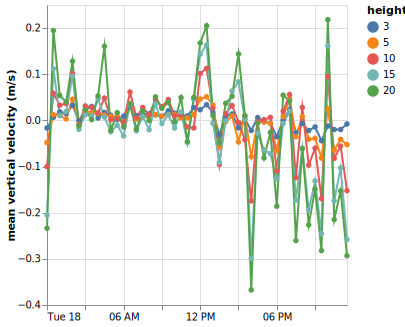

In [6]:
alt.Chart(
    (
        sos_df.query("measurement == 'w'").query("tower == 'c'").query("height > 2")
    ).set_index('time').loc['20230418'].reset_index()
).mark_line(point=True).encode(
    alt.X('time:T').title(None),
    alt.Y('value:Q').title('mean vertical velocity (m/s)'),
    alt.Color('height:N')
).properties(width=300)

# Examine synoptic winds, with doppler lidar (PPI/VAD)

In [7]:
SAIL_DATA_STREAM = 'gucdlprofwind4newsM1.c1'
DATA_STREAM_FILEEXT = '.nc'
output_dir = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", SAIL_DATA_STREAM)

In [8]:
act.discovery.download_arm_data(username, token, SAIL_DATA_STREAM, startdate, enddate, output=output_dir)

[DOWNLOADING] gucdlprofwind4newsM1.c1.20221229.000040.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230214.001421.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230222.001421.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20221231.000040.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230303.001421.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230404.001421.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230103.000040.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20221217.000039.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230116.000039.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230202.000039.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230301.001421.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230511.001420.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230603.001420.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20221218.000040.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230331.001420.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230506.001421.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230127.000040.nc
[DOWNLOADING] gucdlprofwind4new

['/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20221229.000040.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230214.001421.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230222.001421.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20221231.000040.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230303.001421.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230404.001421.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230103.000040.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20221217.000039.nc',
 '/Users/elischw

In [9]:
dl_w_prof_files = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/*.nc")

In [10]:
prof_ds = act.io.read_arm_netcdf(dl_w_prof_files)
prof_ds.time.min(), prof_ds.time.max()

(<xarray.DataArray 'time' ()> Size: 8B
 array('2022-11-30T00:00:39.646250000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()> Size: 8B
 array('2023-06-15T23:59:20.789108000', dtype='datetime64[ns]'))

In [11]:
prof_df = prof_ds.to_dataframe()
prof_df = utils.modify_df_timezone(prof_df.reset_index(), 'UTC', 'US/Mountain').set_index('time')

In [12]:
synoptic_winds_30min = prof_df.query("height > 900").query("height < 2000")[['wind_speed', 'wind_direction']].reset_index().set_index('time').groupby(pd.Grouper(freq='30min')).mean().ffill()

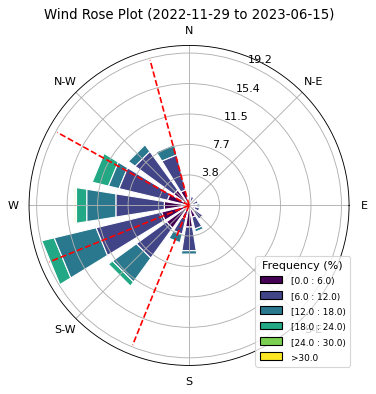

In [13]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import numpy as np
# Create a wind rose plot
ax = WindroseAxes.from_ax(figsize=(5,5),)
ax.bar(
    synoptic_winds_30min['wind_direction'], synoptic_winds_30min['wind_speed'], 
    edgecolor='white', opening=0.8, normed=True,
    bins = np.arange(0, 31, 6)
)

# Add a line at theta = 299 degrees
# theta = np.deg2rad(-299 + 90)  # Convert degrees to radians
ax.plot([np.deg2rad(-202 + 90), np.deg2rad(-202 + 90)], [0, 19], color='red', linestyle='--', label='Theta = 299°')
ax.plot([np.deg2rad(-248 + 90), np.deg2rad(-248 + 90)], [0, 19], color='red', linestyle='--', label='Theta = 299°')

ax.plot([np.deg2rad(-299 + 90), np.deg2rad(-299 + 90)], [0, 19], color='red', linestyle='--', label='Theta = 299°')
ax.plot([np.deg2rad(-345 + 90), np.deg2rad(-345 + 90)], [0, 19], color='red', linestyle='--', label='Theta = 299°')

# Customize the plot
ax.set_title(f"Wind Rose Plot ({synoptic_winds_30min.index.min().date()} to {synoptic_winds_30min.index.max().date()})")
ax.set_legend(title="Frequency (%)", loc='lower right')
plt.show()

<Axes: ylabel='Frequency'>

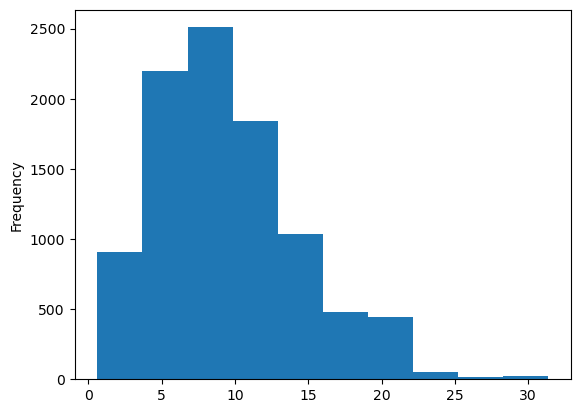

In [14]:
synoptic_winds_30min.wind_speed.plot.hist()

# Classify synoptic wind directions, with doppler lidar (PPI/VAD)

In [15]:
winds_ge10_times = synoptic_winds_30min [ synoptic_winds_30min.wind_speed > 10 ] 
winds_le10_times = synoptic_winds_30min [ synoptic_winds_30min.wind_speed <= 10 ] 

In [16]:
along_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 299)
    & (synoptic_winds_30min.wind_direction < 345 )
].index.values
cross_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 202)
    & (synoptic_winds_30min.wind_direction < 270 )
].index.values
len(cross_valley_wind_times), len(along_valley_wind_times)

(3942, 2044)

In [17]:
pd.Series(cross_valley_wind_times).to_csv('cross_valley_wind_times.csv')
pd.Series(along_valley_wind_times).to_csv('along_valley_wind_times.csv')
pd.Series(winds_ge10_times.index).to_csv('winds_ge10_times.csv')
pd.Series(winds_le10_times.index).to_csv('winds_le10_times.csv')

# Examine vertical profiles of vertical velocity statistics, with doppler lidar (vertical staring)

In [18]:
# Inputs
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
DLW_DATA_STREAM = 'gucdlprofwstats4newsM1.c1'
DLW_DATA_STREAM_FILEEXT = '.cdf'
DLW_OUTPUT_DIR = os.path.join(data_dir, DLW_DATA_STREAM)

Download between start and end date

In [19]:
file_list = act.discovery.download_arm_data(
    username, token, DLW_DATA_STREAM, startdate, enddate, output = DLW_OUTPUT_DIR
)

[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230215.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230523.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230605.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230504.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230309.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230604.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230126.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230518.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20221216.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230205.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20221215.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230502.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230111.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230419.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230113.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230412.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230224.000000.

Or just open existing files between start and end date

In [20]:
files = glob.glob(os.path.join(DLW_OUTPUT_DIR, "*.nc"))
# Function to extract date from filename (adjust regex or slicing as needed)
def extract_date(filename):
    # Assuming filenames have a format like "data_YYYYMMDD.nc"
    basename = os.path.basename(filename)
    date_str = basename.split('gucdlprofwstats4newsM1.c1.')[1].split('.000000')[0]  # Adjust based on your filename format
    return date_str

# Filter files based on date range
file_list = [
    file for file in files
    if startdate.replace('-','') <= extract_date(file) <= enddate.replace('-','')
]

In [21]:
dl_wstats = xr.open_mfdataset(file_list)
dl_wstats = utils.modify_xarray_timezone(
    dl_wstats,
    'UTC',
    'US/Mountain'
)

In [22]:
dl_wstats.time.min(), dl_wstats.time.max()

(<xarray.DataArray 'time' ()> Size: 8B
 array('2022-11-29T17:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()> Size: 8B
 array('2023-06-16T17:50:00.000000000', dtype='datetime64[ns]'))

In [23]:
df_wstats = dl_wstats[['w_variance', 'w_skewness']].to_dataframe()

In [24]:
df_wstats_30min = df_wstats.reset_index().set_index('time').groupby([pd.Grouper(freq='30min'), 'height']).mean().reset_index()
df_wstats_30min


,time,height,w_variance,w_skewness,time (US/Mountain),time (UTC)
0,2022-11-29 17:00:00,15.0,0.000234,-0.379480,2022-11-29 17:10:00,2022-11-30 00:10:00
1,2022-11-29 17:00:00,45.0,1.077502,-0.319172,2022-11-29 17:10:00,2022-11-30 00:10:00
2,2022-11-29 17:00:00,75.0,0.555193,-0.303367,2022-11-29 17:10:00,2022-11-30 00:10:00
3,2022-11-29 17:00:00,105.0,0.693679,-0.316026,2022-11-29 17:10:00,2022-11-30 00:10:00
4,2022-11-29 17:00:00,135.0,0.888906,-0.538809,2022-11-29 17:10:00,2022-11-30 00:10:00
...,...,...,...,...,...,...
1270411,2023-06-16 17:30:00,3855.0,NaN,NaN,2023-06-16 17:40:00,2023-06-16 23:40:00
1270412,2023-06-16 17:30:00,3885.0,NaN,NaN,2023-06-16 17:40:00,2023-06-16 23:40:00
1270413,2023-06-16 17:30:00,3915.0,NaN,NaN,2023-06-16 17:40:00,2023-06-16 23:40:00
1270414,2023-06-16 17:30:00,3945.0,NaN,NaN,2023-06-16 17:40:00,2023-06-16 23:40:00


## Variance

In [25]:
df_wstats_along_valley = df_wstats_30min[df_wstats_30min.time.isin(along_valley_wind_times)].query("height < 2000").assign(synoptic_wind_direction = 'along-valley')
df_wstats_cross_valley = df_wstats_30min[df_wstats_30min.time.isin(cross_valley_wind_times)].query("height < 2000").assign(synoptic_wind_direction = 'cross-valley')

df_wstats_with_synoptic_conditions = pd.concat([
    df_wstats_along_valley[df_wstats_along_valley.time.isin(winds_ge10_times.index)].assign(synoptic_wind_speed = '> 10'),
    df_wstats_along_valley[df_wstats_along_valley.time.isin(winds_le10_times.index)].assign(synoptic_wind_speed = '<= 10'),
    df_wstats_cross_valley[df_wstats_cross_valley.time.isin(winds_ge10_times.index)].assign(synoptic_wind_speed = '> 10'),
    df_wstats_cross_valley[df_wstats_cross_valley.time.isin(winds_le10_times.index)].assign(synoptic_wind_speed = '<= 10')
])

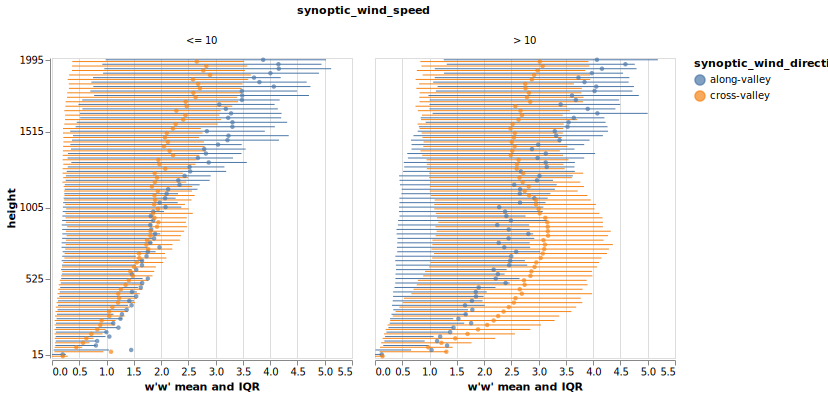

In [26]:
df_wvariance_stats = pd.concat([
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].quantile(0.25).rename('w_variance_lqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].quantile(0.75).rename('w_variance_uqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].mean().rename('w_variance_mean'),
], axis=1).reset_index()

(alt.Chart(df_wvariance_stats).mark_rule().encode(
    alt.X('w_variance_lqr:Q'),
    alt.X2('w_variance_uqr:Q'),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300) + alt.Chart(df_wvariance_stats).mark_circle(size=20).encode(
    alt.X('w_variance_mean:Q').title("w'w' mean and IQR"),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300)).facet(
    column = 'synoptic_wind_speed'
)

In [ ]:
df_wstats_with_synoptic_conditions

## Try to  add the April 18 profile to this plot below

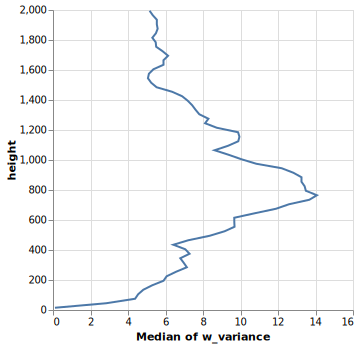

In [51]:
apr18_2000_2100_avgs = df_wstats_with_synoptic_conditions.set_index('time').sort_index().loc['20230418 2000': '20230418 2100']


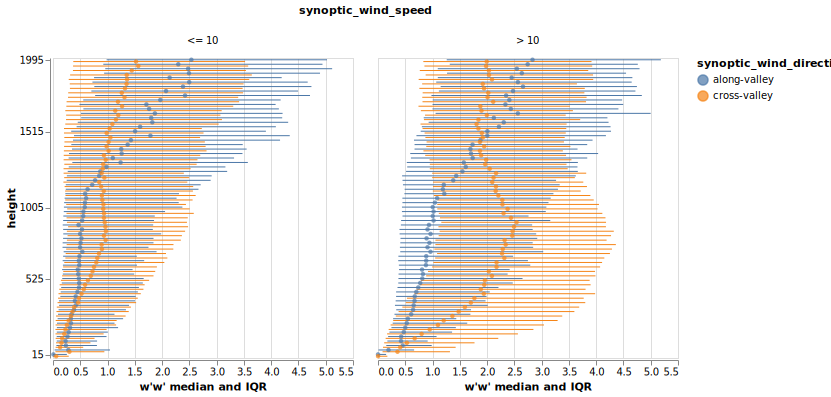

In [75]:
df_wvariance_stats = pd.concat([
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].quantile(0.25).rename('w_variance_lqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].quantile(0.75).rename('w_variance_uqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].median().rename('w_variance_median'),
], axis=1).reset_index()

(
    alt.Chart(df_wvariance_stats).mark_rule().encode(
        alt.X('w_variance_lqr:Q'),
        alt.X2('w_variance_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300) + 
    alt.Chart(df_wvariance_stats).mark_circle(size=20).encode(
        alt.X('w_variance_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
).facet(
        column = 'synoptic_wind_speed'
)

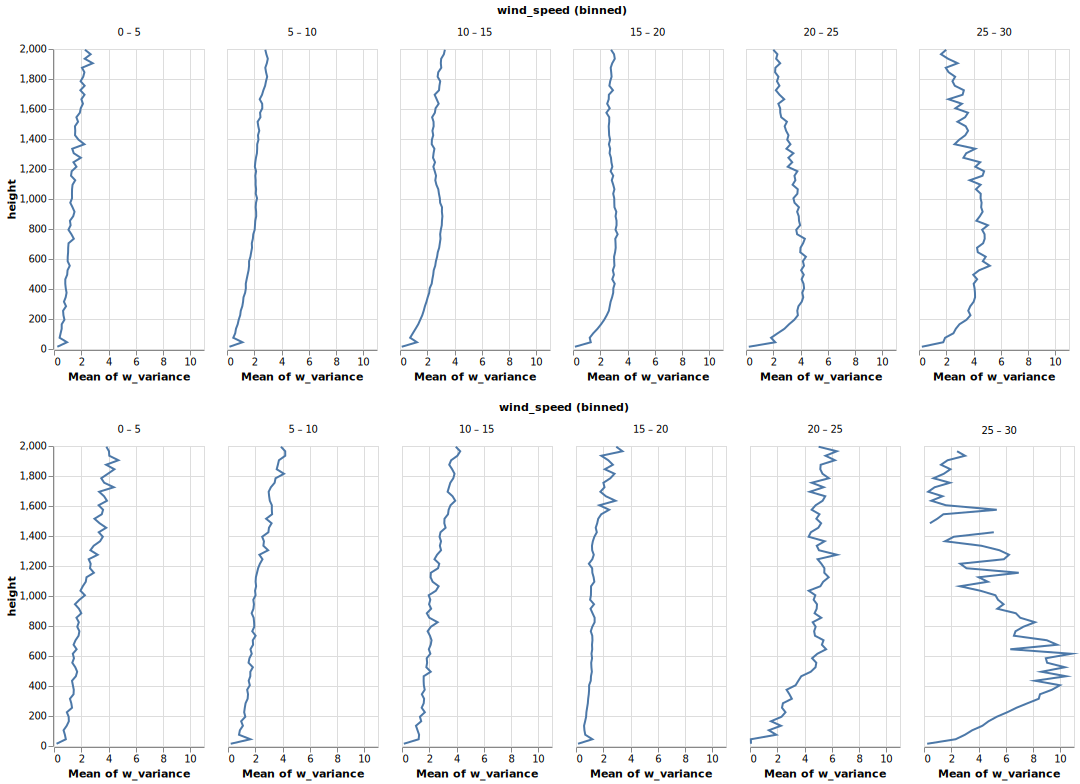

In [28]:
(alt.Chart(
    df_wstats_cross_valley.set_index('time').join(synoptic_winds_30min)
).mark_line().encode(
    alt.X('mean(w_variance)'),
    alt.Y('height:Q'),
    alt.Facet('wind_speed').bin(),
    order='height'
).properties(width=150) & alt.Chart(
    df_wstats_along_valley.set_index('time').join(synoptic_winds_30min)
).mark_line().encode(
    alt.X('mean(w_variance)'),
    alt.Y('height:Q'),
    alt.Facet('wind_speed').bin(),
    order='height'
).properties(width=150)).resolve_scale(y='shared', x='shared')

In [29]:
df_wstats_cross_valley_with_synoptic_wind_bins = df_wstats_with_synoptic_conditions.set_index('time').join(synoptic_winds_30min)
df_wstats_cross_valley_with_synoptic_wind_bins['wind_speed_bin'] = pd.cut(df_wstats_cross_valley_with_synoptic_wind_bins['wind_speed'], [0,5,10,15,20,25,30])
df_wstats_cross_valley_with_synoptic_wind_bins['wind_speed_bin'] = df_wstats_cross_valley_with_synoptic_wind_bins['wind_speed_bin'].apply(lambda interval: f"{interval.left}-{interval.right}")
df_wvariance_stats = pd.concat([
    df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_variance'].quantile(0.25).rename('w_variance_lqr'),
    df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_variance'].quantile(0.75).rename('w_variance_uqr'),
    df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_variance'].mean().rename('w_variance_mean'),
], axis=1).reset_index()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_38095/1336105563.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_variance'].quantile(0.25).rename('w_variance_lqr'),
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_38095/1336105563.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_variance'].quantile(0.75).rename('w_variance_uqr'),
/var/folders/x_/2h52bcjx2p

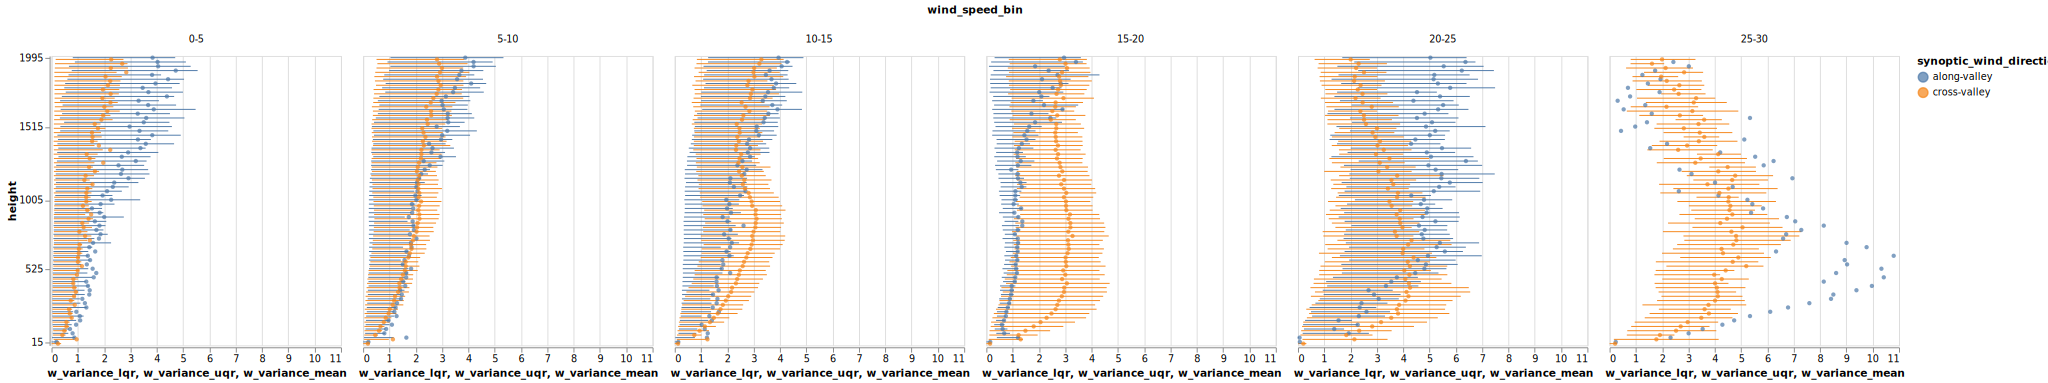

In [30]:
(alt.Chart(df_wvariance_stats).mark_rule().encode(
    alt.X('w_variance_lqr:Q'),
    alt.X2('w_variance_uqr:Q'),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300) + alt.Chart(df_wvariance_stats).mark_circle(size=20).encode(
    alt.X('w_variance_mean:Q'),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300)).facet(
    column = 'wind_speed_bin'
)

## Skewness

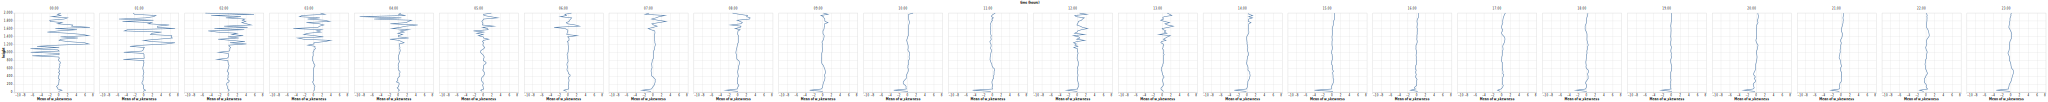

In [31]:
alt.Chart(
    df_wstats_with_synoptic_conditions.set_index('time').loc['20230418'].reset_index()
).mark_line().encode(
    alt.X('mean(w_skewness):Q'),
    alt.Y('height:Q'),
    alt.Facet('hours(time)'),
    order='height'
)

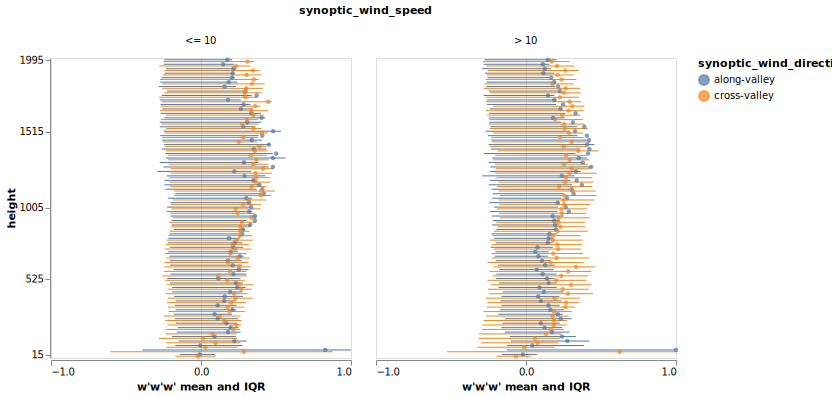

In [33]:
df_wskewness_stats = pd.concat([
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.25).rename('w_skewness_lqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.75).rename('w_skewness_uqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].mean().rename('w_skewness_mean'),
], axis=1).reset_index()

(alt.Chart(df_wskewness_stats).mark_rule().encode(
    alt.X('w_skewness_lqr:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]),
    alt.X2('w_skewness_uqr:Q'),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300) + alt.Chart(df_wskewness_stats).mark_circle(size=20).encode(
    alt.X('w_skewness_mean:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]).title("w'w'w' mean and IQR"),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300)).facet(
    column = 'synoptic_wind_speed'
)

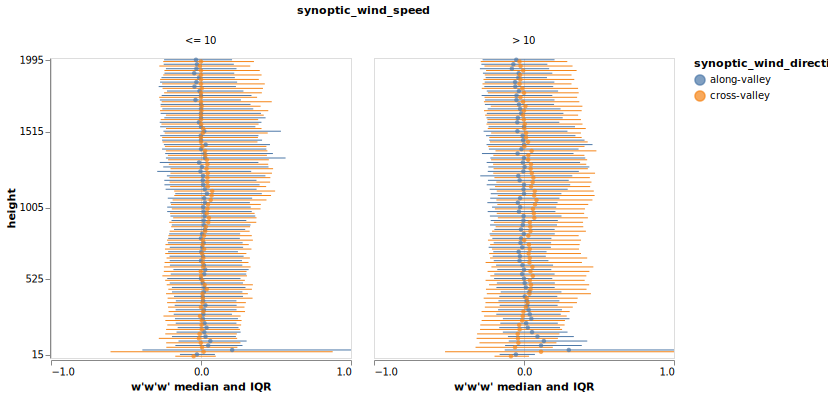

In [32]:
df_wskewness_stats = pd.concat([
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.25).rename('w_skewness_lqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.75).rename('w_skewness_uqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].median().rename('w_skewness_median'),
], axis=1).reset_index()

(alt.Chart(df_wskewness_stats).mark_rule().encode(
    alt.X('w_skewness_lqr:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]),
    alt.X2('w_skewness_uqr:Q'),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300) + alt.Chart(df_wskewness_stats).mark_circle(size=20).encode(
    alt.X('w_skewness_median:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]).title("w'w'w' median and IQR"),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300)).facet(
    column = 'synoptic_wind_speed'
)

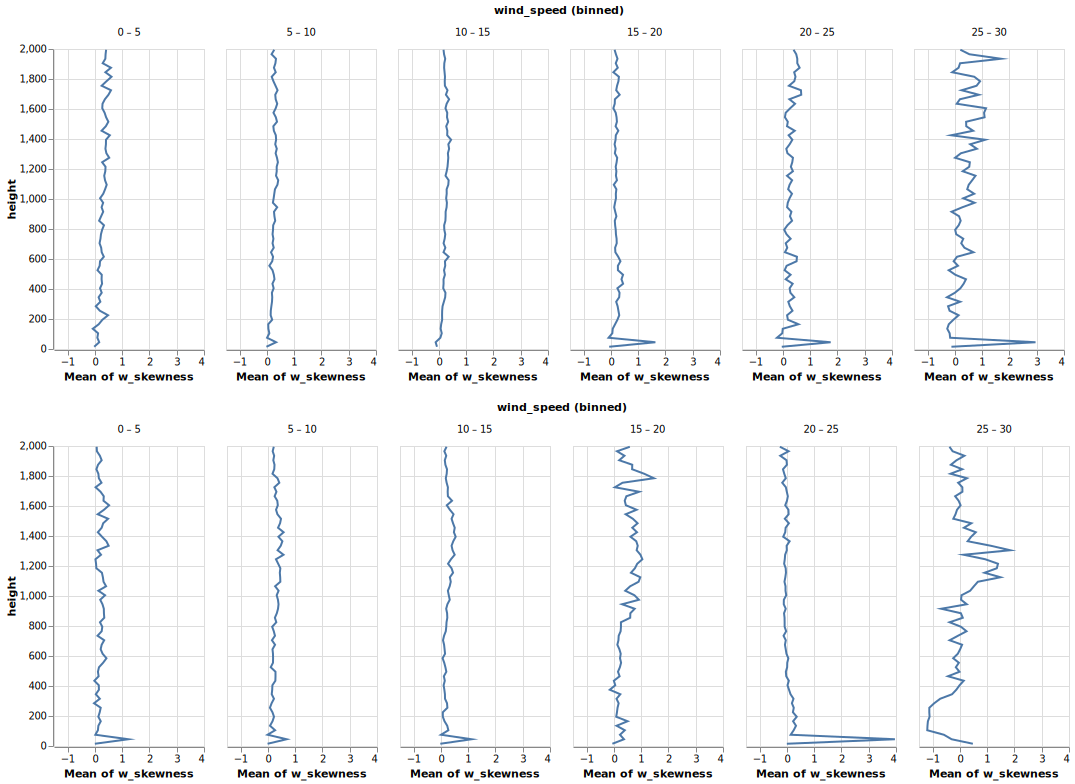

In [28]:
(alt.Chart(
    df_wstats_cross_valley.set_index('time').join(synoptic_winds_30min)
).mark_line().encode(
    alt.X('mean(w_skewness)'),
    alt.Y('height:Q'),
    alt.Facet('wind_speed').bin(),
    order='height'
).properties(width=150) & alt.Chart(
    df_wstats_along_valley.set_index('time').join(synoptic_winds_30min)
).mark_line().encode(
    alt.X('mean(w_skewness)'),
    alt.Y('height:Q'),
    alt.Facet('wind_speed').bin(),
    order='height'
).properties(width=150)).resolve_scale(y='shared', x='shared')

In [29]:
df_wskewness_stats = pd.concat([
    df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_skewness'].quantile(0.25).rename('w_skewness_lqr'),
    df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_skewness'].quantile(0.75).rename('w_skewness_uqr'),
    df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_skewness'].mean().rename('w_skewness_mean'),
], axis=1).reset_index()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19866/1423284833.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_skewness'].quantile(0.25).rename('w_skewness_lqr'),
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19866/1423284833.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_skewness'].quantile(0.75).rename('w_skewness_uqr'),
/var/folders/x_/2h52bcjx2p

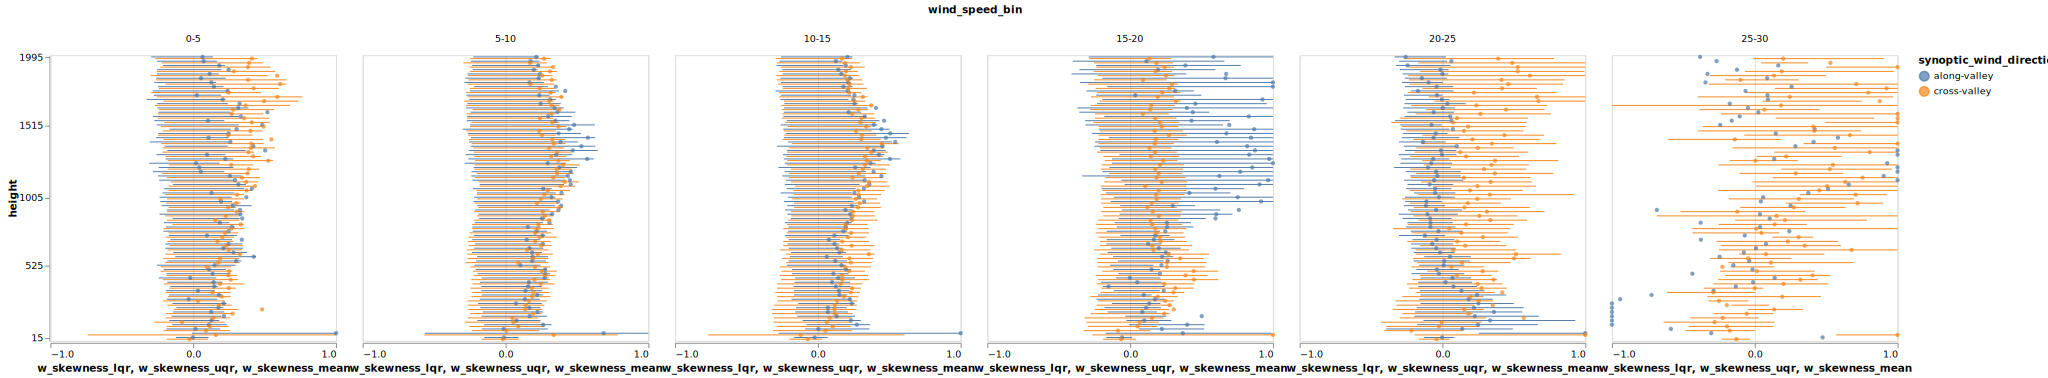

In [30]:
(alt.Chart(df_wskewness_stats).mark_rule().encode(
    alt.X('w_skewness_lqr:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]),
    alt.X2('w_skewness_uqr:Q'),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300) + alt.Chart(df_wskewness_stats).mark_circle(size=20).encode(
    alt.X('w_skewness_mean:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300)).facet(
    column = 'wind_speed_bin'
)

# Compare wind direction shear and mixing intensity

In [31]:
wprof_resampled_ds = prof_df.groupby([pd.Grouper(freq='30min'), 'height'])[['wind_speed', 'wind_direction']].mean().to_xarray()
wprof_resampled_df = wprof_resampled_ds.to_dataframe()
wprof_resampled_df_smooth = pd.DataFrame(
    wprof_resampled_df.groupby(level=0).wind_direction.apply(lambda x: x.rolling(window=3, min_periods=1).mean())
).droplevel(0).query("height < 2000")

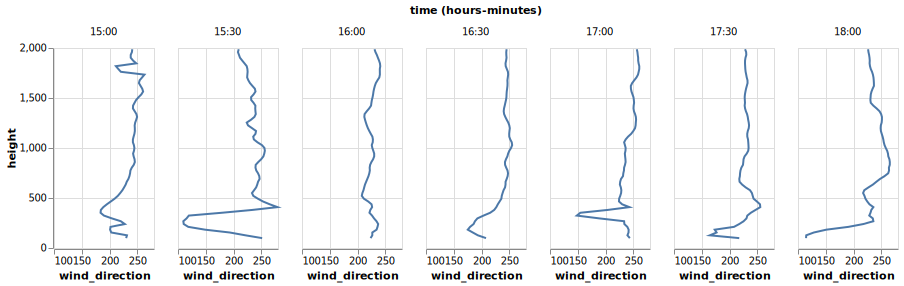

In [32]:
alt.Chart(wprof_resampled_df_smooth.loc['20230418 1500':'20230418 1800'].reset_index()).mark_line().encode(
    alt.X('wind_direction:Q'),
    alt.Y('height:Q'),
    alt.Facet('hoursminutes(time):O'),
    order='height'
).properties(width=100, height=200)